# 2 Colour terms

In this notebook we match the 2MASS reference with the VISTA VIDEO catalogue in order to test the colour terms required to use 2MASS as a calibration catalogue. This notebook is entirely concerned with previously produced catalogues in order to understand how the 2MASS catalogues can be used to calibrate the VISTA imaging and photometry products. We will then compare to the resultant LSST pipeline catalogues. Since the brighter objects are more likely to be used as a reference due to the depth of the VISTA six exposure stacks and also more likely to be saturated in VISTA depending on exposure times we must take care to understand how offsets depend on magnitude.

We are comparing:

### The 2MASS JHKs Vega catalogues

The photometric solution is described here:

https://old.ipac.caltech.edu/2mass/releases/allsky/doc/sec6_4a.html

We take the fluxes for a 0 magnitude object from here for the AB conversion. The colour terms to use these to estimate the VISTA magnitudes are taken from Gonzalez-Fernandez et al (2017?).


### The CASU VISTA catalogues 

These are taken from IRIS. We use the zero point from the header and take the 3 arcsecond aperture photometry with aperture corrections taken from the catalogue.

For comparison here. These are calculated using:

mag = header['MAZPT'] - 2.5 * log10(data['Aper_flux_3']/header['EXPTIME']) - header['APCOR3']

These should be AB magnitudes.

### The public VIDEO VISTA catalogues

These are the catalogues used by HELP and were provided by Matt Jarvis. These are described here:

https://github.com/H-E-L-P/dmu_products/tree/master/dmu0/dmu0_VISTA-VIDEO-private

We are comparing the 3 arcsec corrected aperture AB magnitudes.

### The updated VIDEO SExtractor catalogues

These private catalogues were produced in Oxford and provided by Rebecca Bowler. They contain 2 arcsec aperture magnitudes.

In [1]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table, vstack
import astropy.units as u

import os
from collections import OrderedDict
import yaml
import glob
import numpy as np

import matplotlib.pyplot as plt

from lsst.geom import degrees
import lsst.daf.persistence as dafPersist

import warnings
warnings.filterwarnings('ignore')

In [2]:
MASS_CAT = "../dmu0/dmu0_2MASS/data/fp_2mass.fp_psc_29182.tbl"
#VIDEO_CAT = "../dmu0/dmu0_VISTA/dmu0_VIDEO/data/VIDEO-all_2017-02-12_fullcat_errfix_XMM-LSS.fits"
VIDEO_CAT = "../dmu0/dmu0_VISTA/dmu0_VIDEO/data/VIDEO-all_2017-02-12_fullcat_errfix_v2_XMM-LSS.fits"


Z_TILE_CAT = "../dmu0/dmu0_VISTA/dmu0_VIDEO/data/20121021/v20121021_00293_st_tl_cat.fits"
Y_TILE_CAT = "../dmu0/dmu0_VISTA/dmu0_VIDEO/data/20171027/v20171027_00133_st_tl_cat.fits"
J_TILE_CAT = "../dmu0/dmu0_VISTA/dmu0_VIDEO/data/20121021/v20121021_00577_st_tl_cat.fits"
H_TILE_CAT = "../dmu0/dmu0_VISTA/dmu0_VIDEO/data/20120924/v20120924_00498_st_tl_cat.fits"
Ks_TILE_CAT = "../dmu0/dmu0_VISTA/dmu0_VIDEO/data/20121122/v20121122_00088_st_tl_cat.fits"


OXFORD_HSC_I_CAT = "../dmu3/data/XMMFULL_DR2_MASKVISTA_HSC-I_2.0as_IRAC2.8as_2020_05_26.fits"
OXFORD_VISTA_Ks_CAT = "../dmu3/data/XMMFULL_DR2_MASKVISTA_Ks_2.0as_IRAC2.8as_2020_06_01.fits"



In [3]:
# Conversion from Vega magnitudes to AB is done using values from 
# http://casu.ast.cam.ac.uk/surveys-projects/vista/technical/filter-set
vega_to_ab = {
    "z": 0.521,
    "y": 0.618,
    "j": 0.937,
    "h": 1.384,
    "k": 1.839
} #Previous values

vega_to_ab = {
    "z":0.502,
    "y":0.600,
    "j":0.916,
    "h":1.366,
    "ks":1.827,
    "b118":0.853
}

In [4]:
def flux_to_mag(fluxes, errors_on_fluxes=None):
    """Convert fluxes and errors to magnitudes
    Given flux densities in Jy with associated errors, this function returns
    the corresponding AB magnitudes en errors.
    The magnitudes are computed with this formula:
        M = 2.5 * (23 - log10(F)) - 48.6
    and the errors on magnitudes with this one
        M_err = 2.5/ln(10) * F_err / F
    Parameters
    ----------
    fluxes: float or array-like of floats
        The fluxes in Jy.
    errors_on_fluxes: float or array-like of floats
        The flux errors in Jy None if there are no errors.
    Returns
    -------
    magnitudes: float or array-like of floats
        The AB magnitudes.
    errors: float or array-like of floats
        The errors on AB magnitudes.
    """
    fluxes = np.array(fluxes)
    magnitudes = 2.5 * (23 - np.log10(fluxes)) - 48.6

    if errors_on_fluxes is not None:
        errors_on_fluxes = np.array(errors_on_fluxes)
        errors = 2.5 / np.log(10) * errors_on_fluxes / fluxes
    else:
        errors = None

    return magnitudes, errors

In [5]:
import logging
LOGGER = logging.getLogger(__name__)
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
from collections import Counter
from astropy.table import Table, Column, hstack, vstack
def merge_catalogues(cat_1, cat_2, racol_2, decol_2, radius=0.4*u.arcsec):
    """Merge two catalogues
    This function merges the second catalogue into the first one using the
    given radius to associate identical sources.  This function takes care to
    associate only one source of one catalogue to the other.  The sources that
    may be associated to various counterparts in the other catalogue are
    flagged as “maybe spurious association” with a true value in the
    flag_merged column.  If this column is present in the first catalogue, it's
    content is “inherited” during the merge.
    Parameters
    ----------
    cat_1: astropy.table.Table
        The table containing the first catalogue.  This is the master catalogue
        used during the merge.  If it has a “flag_merged” column it's content
        will be re-used in the flagging of the spurious merges.  This catalogue
        must contain a ‘ra’ and a ‘dec’ columns with the position in decimal
        degrees.
    cat_2: astropy.table.Table
        The table containing the second catalogue.
    racol_2: string
        Name of the column in the second table containing the right ascension
        in decimal degrees.
    decol_2: string
        Name of the column in the second table containing the declination in
        decimal degrees.
    radius: astropy.units.quantity.Quantity
        The radius to associate identical sources in the two catalogues.
    Returns
    -------
    astropy.table.Table
        The merged catalogue.
    """
    cat_1 = cat_1.copy()
    cat_2 = cat_2.copy()
    cat_1['ra'].unit = u.rad
    cat_1['dec'].unit = u.rad
    coords_1 = SkyCoord(cat_1['ra'], cat_1['dec'])

    
    cat_2[racol_2].unit = u.rad
    cat_2[decol_2].unit = u.rad
    coords_2 = SkyCoord(cat_2[racol_2], cat_2[decol_2])

    # Search for sources in second catalogue matching the sources in the first
    # one.
    idx_2, idx_1, d2d, _ = coords_1.search_around_sky(coords_2, radius)

    # We want to flag the possible mis-associations, i.e. the sources in each
    # catalogue that are associated to several sources in the other one, but
    # also all the sources that are associated to a problematic source in the
    # other catalogue (e.g. if two sources in the first catalogue are
    # associated to the same source in the second catalogue, they must be
    # flagged as potentially problematic).
    #
    # Search for duplicate associations
    toflag_idx_1 = np.unique([item for item, count in Counter(idx_1).items()
                              if count > 1])
    toflag_idx_2 = np.unique([item for item, count in Counter(idx_2).items()
                              if count > 1])
    # Flagging the sources associated to duplicates
    dup_associated_in_idx1 = np.in1d(idx_2, toflag_idx_2)
    dup_associated_in_idx2 = np.in1d(idx_1, toflag_idx_1)
    toflag_idx_1 = np.unique(np.concatenate(
        (toflag_idx_1, idx_1[dup_associated_in_idx1])
    ))
    toflag_idx_2 = np.unique(np.concatenate(
        (toflag_idx_2, idx_2[dup_associated_in_idx2])
    ))

    # Adding the flags to the catalogue.  In the second catalogue, the column
    # is named "flag_merged_2" and will be combined to the flag_merged column
    # one the merge is done.
    try:
        cat_1["flag_merged"] |= np.in1d(np.arange(len(cat_1), dtype=int),
                                        toflag_idx_1)
    except KeyError:
        cat_1.add_column(Column(
            data=np.in1d(np.arange(len(cat_1), dtype=int), toflag_idx_1),
            name="flag_merged"
        ))
    try:
        cat_2["flag_merged_2"] |= np.in1d(np.arange(len(cat_2), dtype=int), toflag_idx_2)
    except KeyError:
        cat_2.add_column(Column(
            data=np.in1d(np.arange(len(cat_2), dtype=int), toflag_idx_2),
            name="flag_merged_2"
        ))


    # Now that we have flagged the maybe spurious associations, we want to
    # associate each source of each catalogue to at most one source in the
    # other one.

    # We sort the indices by the distance to take the nearest counterparts in
    # the following steps.
    sort_idx = np.argsort(d2d)
    idx_1 = idx_1[sort_idx]
    idx_2 = idx_2[sort_idx]

    # These array will contain the indexes of the matching sources in both
    # catalogues.
    match_idx_1 = np.array([], dtype=int)
    match_idx_2 = np.array([], dtype=int)

    while len(idx_1) > 0:

        both_first_idx = np.sort(np.intersect1d(
            np.unique(idx_1, return_index=True)[1],
            np.unique(idx_2, return_index=True)[1],
        ))

        new_match_idx_1 = idx_1[both_first_idx]
        new_match_idx_2 = idx_2[both_first_idx]

        match_idx_1 = np.concatenate((match_idx_1, new_match_idx_1))
        match_idx_2 = np.concatenate((match_idx_2, new_match_idx_2))

        # We remove the matching sources in both catalogues.
        to_remove = (np.in1d(idx_1, new_match_idx_1) |
                     np.in1d(idx_2, new_match_idx_2))
        idx_1 = idx_1[~to_remove]
        idx_2 = idx_2[~to_remove]

    # Indices of un-associated object in both catalogues.
    unmatched_idx_1 = np.delete(np.arange(len(cat_1), dtype=int),match_idx_1)
    unmatched_idx_2 = np.delete(np.arange(len(cat_2), dtype=int),match_idx_2)

    # Sources only in cat_1
    only_in_cat_1 = cat_1[unmatched_idx_1]

    # Sources only in cat_2
    only_in_cat_2 = cat_2[unmatched_idx_2]
    # We are using the ra and dec columns from cat_2 for the position.
    only_in_cat_2[racol_2].name = "ra"
    only_in_cat_2[decol_2].name = "dec"

    # Merged table of sources in both catalogues.
    both_in_cat_1_and_cat_2 = hstack([cat_1[match_idx_1], cat_2[match_idx_2]])
    # We don't need the positions from the second catalogue anymore.
    both_in_cat_1_and_cat_2.remove_columns([racol_2, decol_2])

    # Logging the number of rows
    LOGGER.info("There are %s sources only in the first catalogue",
                len(only_in_cat_1))
    LOGGER.info("There are %s sources only in the second catalogue",
                len(only_in_cat_2))
    LOGGER.info("There are %s sources in both catalogues",
                len(both_in_cat_1_and_cat_2))

    merged_catalogue = vstack([only_in_cat_1, both_in_cat_1_and_cat_2,
                               only_in_cat_2])

    # When vertically stacking the catalogues, some values in the flag columns
    # are masked because they did not exist in the catalogue some row originate
    # from. We must set them to the appropriate value.
    for colname in merged_catalogue.colnames:
        if 'flag' in colname:
            merged_catalogue[colname][merged_catalogue[colname].mask] = False

    # We combined the flag_merged flags
    merged_catalogue['flag_merged'] |= merged_catalogue['flag_merged_2']
    merged_catalogue.remove_column('flag_merged_2')

    return merged_catalogue

In [6]:
def clean_table(table):
    """Take a table produced by a VO query and remove all empty columns
    
    Often many columns are empty and make the tables hard to read.
    The function also converts columsn that are objects to strings.
    Object columns prevent writing to fits.
    
    Inputs
    =======
    table,    Astropy.table.Table
        The input table
    
    Returns
    =======
    table,    Astropy.table.Table
         The modified table.
    
    """
    table = table.copy()
    if len(table) == 0:
        return table
    for col in table.colnames:
        #Remove empty columns
        try:
            if np.all(table[col].mask):
                print("Removing empty column: {}".format(col))
                table.remove_column(col)
                continue
        except AttributeError:
            print("{} is not a masked columns".format(col))
            
        #Get rid of column type object from VO queries
        if table[col].dtype == 'object':
            print("Converting column {} type from object to string".format(col) )
            table[col] = table[col].astype(str)
 
        #Get rid of unit '-' from some tables
        if table[col].unit == '-':
            print("Converting column {} unit from '-' to None".format(col) )
            table[col].unit = None   
            
        #replace masked floats with nans     
        if (table[col].dtype == 'float64') or (table[col].dtype == 'float32'):
            table[col].fill_value = np.nan
    
    table = table.filled()
            
    return table


### 2MASS

In [7]:
c_2mass = Table.read(MASS_CAT, format = 'ascii')


In [8]:
#c_2mass['ra'].name = 'v_ra'
#c_2mass['dec'].name = 'v_dec'
c_2mass['j_m'].name = 'j'
c_2mass['j_cmsig'].name = 'j_err'
c_2mass['h_m'].name = 'h'
c_2mass['h_cmsig'].name = 'h_err'
c_2mass['k_m'].name = 'ks'
c_2mass['k_cmsig'].name = 'ks_err'
c_2mass = c_2mass['ra', 'dec', 'j','j_err','h','h_err','ks','ks_err']
c_2mass['ra'].convert_unit_to(u.rad)
c_2mass['dec'].convert_unit_to(u.rad)


### HELP

In [9]:
imported_columns = OrderedDict({
        'ID':              'video_id', 
        'ALPHA_J2000':     'ra', 
        'DELTA_J2000':     'dec', 
    
        'J_CLASS_STAR':    'vista_stellarity', 
    
        'Y_MAG_APER_3':    'm_ap_vista_y', 
        'Y_MAGERR_APER_3': 'merr_ap_vista_y', 
        'Y_MAG_AUTO':      'm_vista_y', 
        'Y_MAGERR_AUTO':   'merr_vista_y',
    
        'J_MAG_APER_3':    'm_ap_vista_j', 
        'J_MAGERR_APER_3': 'merr_ap_vista_j', 
        'J_MAG_AUTO':      'm_vista_j', 
        'J_MAGERR_AUTO':   'merr_vista_j',
    
        'H_MAG_APER_3':    'm_ap_vista_h', 
        'H_MAGERR_APER_3': 'merr_ap_vista_h', 
        'H_MAG_AUTO':      'm_vista_h', 
        'H_MAGERR_AUTO':   'merr_vista_h',
  
        'K_MAG_APER_3':    'm_ap_vista_ks', 
        'K_MAGERR_APER_3': 'merr_ap_vista_ks', 
        'K_MAG_AUTO':      'm_vista_ks', 
        'K_MAGERR_AUTO':   'merr_vista_ks',

})


help_cat = Table.read(VIDEO_CAT
                      )[list(imported_columns)]
for column in imported_columns:
    help_cat[column].name = 'help_' + imported_columns[column]
help_cat['help_ra'].unit = u.deg
help_cat['help_dec'].unit = u.deg
help_cat['help_ra'].convert_unit_to(u.rad)
help_cat['help_dec'].convert_unit_to(u.rad)

### CASU Tiles

In [10]:
TILE_COLS = ['RA', 'DEC', 'Classification', 'Aper_flux_3', 'Aper_flux_3_err']

y_tile_cat = Table.read(Y_TILE_CAT)[TILE_COLS]
y_magzpt = fits.open(Y_TILE_CAT)[1].header['MAGZPT']
y_exptime = fits.open(Y_TILE_CAT)[1].header['EXPTIME']
y_apcor3 = fits.open(Y_TILE_CAT)[1].header['APCOR3']
y_tile_cat['m_ap_vista_y'] = y_magzpt - 2.5 * np.log10(y_tile_cat['Aper_flux_3']/y_exptime) - y_apcor3
y_tile_cat['merr_ap_vista_y'] = (2.5 / np.log(10))* (y_tile_cat['Aper_flux_3_err'] / y_tile_cat['Aper_flux_3'])
y_tile_cat['m_ap_vista_y'] += vega_to_ab['y']
for c in y_tile_cat.colnames:
    y_tile_cat[c].name = 'y_tile_' + c
y_tile_cat['y_tile_RA'].unit = u.rad
y_tile_cat['y_tile_DEC'].unit = u.rad

j_tile_cat = Table.read(J_TILE_CAT)[TILE_COLS]
j_magzpt = fits.open(J_TILE_CAT)[1].header['MAGZPT']
j_exptime = fits.open(J_TILE_CAT)[1].header['EXPTIME']
j_apcor3 = fits.open(J_TILE_CAT)[1].header['APCOR3']
j_tile_cat['m_ap_vista_j'] = j_magzpt - 2.5 * np.log10(j_tile_cat['Aper_flux_3']/j_exptime) - j_apcor3
j_tile_cat['merr_ap_vista_j'] = (2.5 / np.log(10))* (j_tile_cat['Aper_flux_3_err'] / j_tile_cat['Aper_flux_3'])
j_tile_cat['m_ap_vista_j'] += vega_to_ab['j']
for c in j_tile_cat.colnames:
    j_tile_cat[c].name = 'j_tile_' + c
j_tile_cat['j_tile_RA'].unit = u.rad
j_tile_cat['j_tile_DEC'].unit = u.rad

h_tile_cat = Table.read(H_TILE_CAT)[TILE_COLS]
h_magzpt = fits.open(H_TILE_CAT)[1].header['MAGZPT']
h_exptime = fits.open(H_TILE_CAT)[1].header['EXPTIME']
h_apcor3 = fits.open(H_TILE_CAT)[1].header['APCOR3']
h_tile_cat['m_ap_vista_h'] = h_magzpt - 2.5 * np.log10(h_tile_cat['Aper_flux_3']/h_exptime) - h_apcor3
h_tile_cat['merr_ap_vista_h'] = (2.5 / np.log(10))* (h_tile_cat['Aper_flux_3_err'] / h_tile_cat['Aper_flux_3'])
h_tile_cat['m_ap_vista_h'] += vega_to_ab['h']
for c in h_tile_cat.colnames:
    h_tile_cat[c].name = 'h_tile_' + c
h_tile_cat['h_tile_RA'].unit = u.rad
h_tile_cat['h_tile_DEC'].unit = u.rad

ks_tile_cat = Table.read(Ks_TILE_CAT)[TILE_COLS]
ks_magzpt = fits.open(Ks_TILE_CAT)[1].header['MAGZPT']
ks_exptime = fits.open(Ks_TILE_CAT)[1].header['EXPTIME']
ks_apcor3 = fits.open(Ks_TILE_CAT)[1].header['APCOR3']
ks_tile_cat['m_ap_vista_ks'] = ks_magzpt - 2.5 * np.log10(ks_tile_cat['Aper_flux_3']/ks_exptime) - ks_apcor3
ks_tile_cat['merr_ap_vista_ks'] = (2.5 / np.log(10))* (ks_tile_cat['Aper_flux_3_err'] / ks_tile_cat['Aper_flux_3'])
ks_tile_cat['m_ap_vista_ks'] += vega_to_ab['ks']
for c in ks_tile_cat.colnames:
    ks_tile_cat[c].name = 'ks_tile_' + c
ks_tile_cat['ks_tile_RA'].unit = u.rad
ks_tile_cat['ks_tile_DEC'].unit = u.rad

In [11]:
y_tile_cat[:5]

y_tile_RA,y_tile_DEC,y_tile_Classification,y_tile_Aper_flux_3,y_tile_Aper_flux_3_err,y_tile_m_ap_vista_y,y_tile_merr_ap_vista_y
rad,rad,Flag,ADU,ADU,ADU,ADU
float32,float32,float32,float32,float32,float32,float32
0.62173504,-0.071107306,1.0,376.81955,19.008017,20.814703,0.0547681
0.6217615,-0.07111136,-1.0,133.35863,17.684334,21.942484,0.14397658
0.62168986,-0.07110744,1.0,1568.7545,24.475672,19.266148,0.01693963
0.62269235,-0.07110706,-1.0,7966.073,43.302628,17.501926,0.0059019327
0.62173235,-0.07111804,1.0,200.51881,18.061842,21.49965,0.09779827


In [12]:

TEST_LIMS = {
    'ra_min':np.min(y_tile_cat['y_tile_RA']),
    'ra_max':np.max(y_tile_cat['y_tile_RA']),
    'dec_min':np.min(y_tile_cat['y_tile_DEC']),
    'dec_max':np.max(y_tile_cat['y_tile_DEC']),
}

### Oxford Ks Selected

In [13]:
imported_columns = OrderedDict({
        'ID_se':              'id', 
        'RA':     'ra', 
        'DEC':     'dec', 
    
        #'J_CLASS_STAR':    'vista_stellarity', 
     
        #HSC GRIZY?
        'flux_Y':    'f_ap_vista_y', 
        'err_Y': 'ferr_ap_vista_y', #Flux error? ~E-30

    
        'flux_J':    'f_ap_vista_j', 
        'err_J': 'ferr_ap_vista_j', 

    
        'flux_H':    'f_ap_vista_h', 
        'err_H': 'ferr_ap_vista_h', 

  
        'flux_Ks':    'f_ap_vista_ks', 
        'err_Ks': 'ferr_ap_vista_ks', 


})


oxford_ks_cat = Table.read(OXFORD_VISTA_Ks_CAT
                      )[list(imported_columns)]
for column in imported_columns:
    oxford_ks_cat[column].name = 'oxford_ks_' + imported_columns[column]
    

    
oxford_ks_cat['oxford_ks_ra'].unit = u.deg
oxford_ks_cat['oxford_ks_dec'].unit = u.deg
oxford_ks_cat['oxford_ks_ra'].convert_unit_to(u.rad)
oxford_ks_cat['oxford_ks_dec'].convert_unit_to(u.rad)

print(len(oxford_ks_cat))
mask = oxford_ks_cat['oxford_ks_ra'] <  np.max(ks_tile_cat['ks_tile_RA'])
mask &= oxford_ks_cat['oxford_ks_ra'] >  np.min(ks_tile_cat['ks_tile_RA'])
mask &= oxford_ks_cat['oxford_ks_dec'] <  np.max(ks_tile_cat['ks_tile_DEC'])
mask &= oxford_ks_cat['oxford_ks_dec'] >  np.min(ks_tile_cat['ks_tile_DEC'])
oxford_ks_cat = oxford_ks_cat[mask]
print(len(oxford_ks_cat))

1674689
609199


In [14]:
u.erg/u.second/u.cm**2/u.Hz

Unit("erg / (cm2 Hz s)")

In [15]:
ex =  1*u.erg/u.second/u.cm**2/u.Hz

In [16]:
ex.to(u.uJy)

<Quantity 1.e+29 uJy>

In [17]:
#convert units and fluxes to mags
#From Rebecca units are in cgs (ergs/s/cm2)
#I presume she means cgs flux densities (ergs/s/cm2/Hz) - check for large offset
for col in oxford_ks_cat.colnames:
    if col.startswith('oxford_ks_f_'):
        err_col = col.replace('_f_', '_ferr_')
        oxford_ks_cat[col].unit = u.erg/u.second/u.cm**2/u.Hz
        oxford_ks_cat[err_col].unit = u.erg/u.second/u.cm**2/u.Hz
        oxford_ks_cat[col].convert_unit_to(u.uJy)
        oxford_ks_cat[err_col].convert_unit_to(u.uJy)
        m,merr = flux_to_mag(oxford_ks_cat[col]*1e-6,oxford_ks_cat[err_col]*1e-6) # expects Jansky
        oxford_ks_cat[col.replace('_f_', '_m_')] = m
        oxford_ks_cat[err_col.replace('_ferr_', '_merr_')] = merr

In [18]:
oxford_ks_cat[:5]

oxford_ks_id,oxford_ks_ra,oxford_ks_dec,oxford_ks_f_ap_vista_y,oxford_ks_ferr_ap_vista_y,oxford_ks_f_ap_vista_j,oxford_ks_ferr_ap_vista_j,oxford_ks_f_ap_vista_h,oxford_ks_ferr_ap_vista_h,oxford_ks_f_ap_vista_ks,oxford_ks_ferr_ap_vista_ks,oxford_ks_m_ap_vista_y,oxford_ks_merr_ap_vista_y,oxford_ks_m_ap_vista_j,oxford_ks_merr_ap_vista_j,oxford_ks_m_ap_vista_h,oxford_ks_merr_ap_vista_h,oxford_ks_m_ap_vista_ks,oxford_ks_merr_ap_vista_ks
,rad,rad,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,,,,,,,,
int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
256144,0.6093914,-0.0880807,0.02876323,0.11632181039791559,0.1645023,0.23211530051368381,-0.006849915,0.2564513987439549,0.6565590288067661,0.3223491519300123,27.752905833601112,4.390841964325705,25.859569799436223,1.531990276509417,nan,-40.648467957354285,24.356815555000217,0.5330612016097926
447376,0.6093914,-0.0806008,10.16075,0.5080375304122048,13.08564,0.6542821354476445,14.51811,0.725905706590407,19.222302567409805,0.9611151097947772,21.3826856372554,0.054286816088472516,21.108012429590453,0.05428681398315863,20.99522446139114,0.054286809084536904,20.690486477617533,0.054286809188691686
225919,0.6093914,-0.0892656,0.1661991,0.089557862314394,0.3943575,0.14381427796308494,0.3818701,0.24785993734428194,0.21321670230785802,0.28864672348650516,25.84842858713383,0.5850587427319613,24.91027464623476,0.39594620398716085,24.94521092185702,0.7047174480412959,25.577946944751325,1.4698388760445493
85386,0.6093916,-0.0948395,-0.002199297,0.07459019141420198,0.2368061,0.11467708824624948,0.4773257,0.31548208846628706,0.6404271661580803,0.2896392510100556,nan,-36.82325530718164,25.464017615174633,0.5257847957278889,24.70296302920962,0.7176029887147809,24.383825635267563,0.49103448098112396
89252,0.6093916,-0.0946260,2.58536,0.12926797744872115,3.272592,0.16362960554644612,3.933023,0.23214012815106394,4.126317269844358,0.2731576608187515,22.868697634220034,0.05428681063283081,22.612770302198804,0.05428681023790648,22.413183809512113,0.06408377156198956,22.361093456148744,0.07187454152529243


### Oxford HSC-I Selected

In [19]:
imported_columns = OrderedDict({
        'ID_se':              'id', 
        'RA':     'ra', 
        'DEC':     'dec', 
    
        #'J_CLASS_STAR':    'vista_stellarity', 
     
        #HSC GRIZY?
        'flux_Y':    'f_ap_vista_y', 
        'err_Y': 'ferr_ap_vista_y', #Flux error? ~E-30

    
        'flux_J':    'f_ap_vista_j', 
        'err_J': 'ferr_ap_vista_j', 

    
        'flux_H':    'f_ap_vista_h', 
        'err_H': 'ferr_ap_vista_h', 

  
        'flux_Ks':    'f_ap_vista_ks', 
        'err_Ks': 'ferr_ap_vista_ks', 


})


oxford_i_cat = Table.read(OXFORD_HSC_I_CAT
                      )[list(imported_columns)]
for column in imported_columns:
    oxford_i_cat[column].name = 'oxford_i_' + imported_columns[column]
    

    
oxford_i_cat['oxford_i_ra'].unit = u.deg
oxford_i_cat['oxford_i_dec'].unit = u.deg
oxford_i_cat['oxford_i_ra'].convert_unit_to(u.rad)
oxford_i_cat['oxford_i_dec'].convert_unit_to(u.rad)

print(len(oxford_i_cat))
mask = oxford_i_cat['oxford_i_ra'] <  np.max(ks_tile_cat['ks_tile_RA'])
mask &= oxford_i_cat['oxford_i_ra'] >  np.min(ks_tile_cat['ks_tile_RA'])
mask &= oxford_i_cat['oxford_i_dec'] <  np.max(ks_tile_cat['ks_tile_DEC'])
mask &= oxford_i_cat['oxford_i_dec'] >  np.min(ks_tile_cat['ks_tile_DEC'])
oxford_i_cat = oxford_i_cat[mask]
print(len(oxford_i_cat))

1192592
408006


In [20]:
#convert units and fluxes to mags
#From Rebecca units are in cgs (ergs/s/cm2)
for col in oxford_i_cat.colnames:
    if col.startswith('oxford_i_f_'):
        err_col = col.replace('_f_', '_ferr_')
        oxford_i_cat[col].unit = u.erg/u.second/u.cm**2/u.Hz
        oxford_i_cat[err_col].unit = u.erg/u.second/u.cm**2/u.Hz
        oxford_i_cat[col].convert_unit_to(u.uJy)
        oxford_i_cat[err_col].convert_unit_to(u.uJy)
        m,merr = flux_to_mag(oxford_i_cat[col]*1e-6,oxford_i_cat[err_col]*1e-6) # expects Jansky
        oxford_i_cat[col.replace('_f_', '_m_')] = m
        oxford_i_cat[err_col.replace('_ferr_', '_merr_')] = merr

In [21]:
oxford_i_cat[:5]

oxford_i_id,oxford_i_ra,oxford_i_dec,oxford_i_f_ap_vista_y,oxford_i_ferr_ap_vista_y,oxford_i_f_ap_vista_j,oxford_i_ferr_ap_vista_j,oxford_i_f_ap_vista_h,oxford_i_ferr_ap_vista_h,oxford_i_f_ap_vista_ks,oxford_i_ferr_ap_vista_ks,oxford_i_m_ap_vista_y,oxford_i_merr_ap_vista_y,oxford_i_m_ap_vista_j,oxford_i_merr_ap_vista_j,oxford_i_m_ap_vista_h,oxford_i_merr_ap_vista_h,oxford_i_m_ap_vista_ks,oxford_i_merr_ap_vista_ks
,rad,rad,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,,,,,,,,
int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
309560,0.6093914,-0.0858960,4.231586,0.21157929185014163,5.700357,0.2850178834642171,6.221993,0.31109965808071394,8.230868,0.4115433934093248,22.3337421052671,0.05428680986257306,22.010244801973336,0.05428681363167075,21.915176194743246,0.0542868111568596,21.611385881079435,0.054286808032611544
533228,0.6093914,-0.0783188,1.844907,0.09224534532445373,3.242784,0.16213917769860145,4.215316,0.22270871872305711,5.387093,0.32988880529292436,23.23506387740219,0.054286811191030876,22.622705103472548,0.05428681063562383,22.337924758061412,0.057362945363844224,22.071613755518136,0.06648710149287991
94296,0.6093914,-0.0936138,0.5352964,0.07986102672744579,0.6883463,0.11111696435120096,0.7805069,0.196707559913362,0.7497404,0.27123158687844434,24.57851416764084,0.16198129860986696,24.305482536811105,0.17526601122489444,24.169058072812568,0.2736330808692011,24.212722725070158,0.3927838971859081
359579,0.6093915,-0.0841684,0.2652018,0.06993147498913821,0.3315905,0.12128108219794172,0.4596246,0.19900783930690338,0.1539623,0.2592870258111857,25.341058733510728,0.28629944215802144,25.09849492271814,0.3971141412652217,24.74399177704563,0.4701010435388505,25.9314641131187,1.82848226074768
398322,0.6093916,-0.0828369,0.3306854,0.09900285643499249,0.05155178,0.1312892292324004,0.4039827,0.2316451695712152,0.1962243,0.28261359403588715,25.101462289419764,0.32505508237128383,27.119390765664967,2.7650928864535116,24.884093151443075,0.6225651828431948,25.6681179812175,1.5637400543850408


### VISTA VHS public catalogues

In [22]:
# Bands: Y,J,H,K
imported_columns = OrderedDict({
        'SOURCEID': "id",
        'ra': "ra",
        'dec': "dec",
        'PSTAR':  "stellarity",
        'YPETROMAG': "m_vista_y", 
        'YPETROMAGERR': "merr_vista_y", 
        'YAPERMAG3': "m_ap_vista_y", 
        'YAPERMAG3ERR': "merr_ap_vista_y",
        'JPETROMAG': "m_vista_j", 
        'JPETROMAGERR': "merr_vista_j", 
        'JAPERMAG3': "m_ap_vista_j", 
        'JAPERMAG3ERR': "merr_ap_vista_j",        
        'HPETROMAG': "m_vista_h", 
        'HPETROMAGERR': "merr_vista_h", 
        'HAPERMAG3': "m_ap_vista_h", 
        'HAPERMAG3ERR': "merr_ap_vista_h",        
        'KSPETROMAG': "m_vista_ks", 
        'KSPETROMAGERR': "merr_vista_ks", 
        'KSAPERMAG3': "m_ap_vista_ks", 
        'KSAPERMAG3ERR': "merr_ap_vista_ks",
    })


vhs_cat = Table.read("../dmu0/dmu0_VISTA/dmu0_VHS/data/VHS_XMM-LSS.fits")[list(imported_columns)]
for column in imported_columns:
    vhs_cat[column].name = imported_columns[column]

for c in vhs_cat.colnames:
    vhs_cat[c].name = 'vhs_' + c

In [23]:
# Coverting from Vega to AB and adding flux and band-flag columns
for col in vhs_cat.colnames:
    if col.startswith('vhs_m_'):
        
        errcol = "vhs_merr{}".format(col[5:])
        
        # Some object have a magnitude to 0, we suppose this means missing value
        vhs_cat[col][vhs_cat[col] <= 0] = np.nan
        vhs_cat[errcol][vhs_cat[errcol] <= 0] = np.nan 
        
        # Convert magnitude from Vega to AB
        vhs_cat[col] += vega_to_ab[col.split('_')[-1]]


In [24]:
col

'vhs_merr_ap_vista_ks'

In [25]:
vhs_cat[:10].show_in_notebook()

idx,vhs_id,vhs_ra,vhs_dec,vhs_stellarity,vhs_m_vista_y,vhs_merr_vista_y,vhs_m_ap_vista_y,vhs_merr_ap_vista_y,vhs_m_vista_j,vhs_merr_vista_j,vhs_m_ap_vista_j,vhs_merr_ap_vista_j,vhs_m_vista_h,vhs_merr_vista_h,vhs_m_ap_vista_h,vhs_merr_ap_vista_h,vhs_m_vista_ks,vhs_merr_vista_ks,vhs_m_ap_vista_ks,vhs_merr_ap_vista_ks
,,deg,deg,,,,,,,,,,,,,,,,,
0,472534730838,33.72832354037762,-5.832482775355095,0.9,nan,nan,nan,nan,20.480442,0.19933957,20.389828,0.11976809,nan,nan,nan,nan,nan,nan,nan,nan
1,472534730845,33.72849357021899,-5.833156395257119,0.05,nan,nan,nan,nan,20.55174,0.27726412,20.586031,0.15250885,nan,nan,nan,nan,nan,nan,nan,nan
2,472534730852,33.74677655484786,-5.833540878673026,0.48648646,nan,nan,nan,nan,22.62293,1.389962,21.296577,0.27036425,nan,nan,nan,nan,20.794405,0.4152943,19.829247,0.13287356
3,472534730861,33.67178086729373,-5.834132174059466,0.9,nan,nan,nan,nan,21.112692,0.3101439,21.276556,0.2876344,nan,nan,nan,nan,nan,nan,nan,nan
4,472534730871,33.7467840651521,-5.8342268070226275,0.8200836,nan,nan,nan,nan,23.321838,3.3202274,20.596815,0.1462755,18.865591,0.11399704,19.290083,0.075099066,19.498425,0.22438025,19.099346,0.06765489
5,472534730881,33.65485065811903,-5.834257860498843,0.9446064,nan,nan,nan,nan,20.334944,0.29218352,20.555645,0.14140964,19.114426,0.12476045,19.4816,0.090296336,19.942179,0.32215127,19.179087,0.07259629
6,472534730980,33.651790602249974,-5.841698056981796,0.05,nan,nan,nan,nan,21.097923,0.3418129,21.154356,0.24365446,nan,nan,nan,nan,nan,nan,nan,nan
7,472534731059,33.63546112985156,-5.846618065857062,0.05,nan,nan,nan,nan,21.271177,0.40076363,21.255035,0.2699015,nan,nan,nan,nan,nan,nan,nan,nan
8,472534731099,33.686538660597,-5.848632167533669,0.05,nan,nan,nan,nan,20.968729,0.2717281,21.169107,0.25905043,nan,nan,nan,nan,nan,nan,nan,nan


## Merge the catalogues

We use 0.4 arcsec match starting with 2MASS. This should be low enough to exclude too many false matches but may remove some fraction of good matches.

In [26]:

merge  = merge_catalogues( c_2mass, help_cat, 'help_ra', 'help_dec', radius=0.6*u.arcsec)
merge  = merge_catalogues( merge, y_tile_cat, 'y_tile_RA', 'y_tile_DEC', radius=0.6*u.arcsec)
merge  = merge_catalogues( merge, j_tile_cat, 'j_tile_RA', 'j_tile_DEC', radius=0.6*u.arcsec)
merge  = merge_catalogues( merge, h_tile_cat, 'h_tile_RA', 'h_tile_DEC', radius=0.6*u.arcsec)
merge  = merge_catalogues( merge, ks_tile_cat, 'ks_tile_RA', 'ks_tile_DEC', radius=0.6*u.arcsec)
merge  = merge_catalogues( merge, oxford_i_cat, 'oxford_i_ra', 'oxford_i_dec', radius=0.6*u.arcsec)
merge  = merge_catalogues( merge, oxford_ks_cat, 'oxford_ks_ra', 'oxford_ks_dec', radius=0.6*u.arcsec)
merge = clean_table(merge)


In [27]:
len(merge)

898932

In [28]:
c0=1.827+0.011 

c1=0.006
c2=0.0
primary = merge['ks']
secondary = merge['j']
merge['corrected_m_2mass_ks'] = primary + c0 + c1*(primary - secondary)



In [29]:
#These taken from http://www.ipac.caltech.edu/2mass/releases/allsky/doc/sec6_4a.html
# The AB zero point is 3631 Jy
j_2mass_to_ab = 2.5 * np.log10(3631/1594)
h_2mass_to_ab = 2.5 * np.log10(3631/1024)
ks_2mass_to_ab = 2.5 * np.log10(3631/666.7)
print(j_2mass_to_ab,h_2mass_to_ab,ks_2mass_to_ab)


0.8938448296319969 1.3743157306827007 1.840239484468321


In [30]:
 merge[:10]

ra,dec,j,j_err,h,h_err,ks,ks_err,flag_merged,help_video_id,help_vista_stellarity,help_m_ap_vista_y,help_merr_ap_vista_y,help_m_vista_y,help_merr_vista_y,help_m_ap_vista_j,help_merr_ap_vista_j,help_m_vista_j,help_merr_vista_j,help_m_ap_vista_h,help_merr_ap_vista_h,help_m_vista_h,help_merr_vista_h,help_m_ap_vista_ks,help_merr_ap_vista_ks,help_m_vista_ks,help_merr_vista_ks,y_tile_Classification,y_tile_Aper_flux_3,y_tile_Aper_flux_3_err,y_tile_m_ap_vista_y,y_tile_merr_ap_vista_y,j_tile_Classification,j_tile_Aper_flux_3,j_tile_Aper_flux_3_err,j_tile_m_ap_vista_j,j_tile_merr_ap_vista_j,h_tile_Classification,h_tile_Aper_flux_3,h_tile_Aper_flux_3_err,h_tile_m_ap_vista_h,h_tile_merr_ap_vista_h,ks_tile_Classification,ks_tile_Aper_flux_3,ks_tile_Aper_flux_3_err,ks_tile_m_ap_vista_ks,ks_tile_merr_ap_vista_ks,oxford_i_id,oxford_i_f_ap_vista_y,oxford_i_ferr_ap_vista_y,oxford_i_f_ap_vista_j,oxford_i_ferr_ap_vista_j,oxford_i_f_ap_vista_h,oxford_i_ferr_ap_vista_h,oxford_i_f_ap_vista_ks,oxford_i_ferr_ap_vista_ks,oxford_i_m_ap_vista_y,oxford_i_merr_ap_vista_y,oxford_i_m_ap_vista_j,oxford_i_merr_ap_vista_j,oxford_i_m_ap_vista_h,oxford_i_merr_ap_vista_h,oxford_i_m_ap_vista_ks,oxford_i_merr_ap_vista_ks,oxford_ks_id,oxford_ks_f_ap_vista_y,oxford_ks_ferr_ap_vista_y,oxford_ks_f_ap_vista_j,oxford_ks_ferr_ap_vista_j,oxford_ks_f_ap_vista_h,oxford_ks_ferr_ap_vista_h,oxford_ks_f_ap_vista_ks,oxford_ks_ferr_ap_vista_ks,oxford_ks_m_ap_vista_y,oxford_ks_merr_ap_vista_y,oxford_ks_m_ap_vista_j,oxford_ks_merr_ap_vista_j,oxford_ks_m_ap_vista_h,oxford_ks_merr_ap_vista_h,oxford_ks_m_ap_vista_ks,oxford_ks_merr_ap_vista_ks,corrected_m_2mass_ks
rad,rad,mag,mag,mag,mag,mag,mag,,,,,,,,,,,,,,,,,,,,Flag,ADU,ADU,ADU,ADU,Flag,ADU,ADU,ADU,ADU,Flag,ADU,ADU,ADU,ADU,Flag,ADU,ADU,ADU,ADU,,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,,,,,,,,,,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,,,,,,,,,mag
float64,float64,float64,float64,float64,float64,float64,float64,bool,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.5759674,-0.1087200,15.391,0.063,15.075,0.1,15.228,0.195,False,999999,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,999999,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,999999,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,17.065022
0.5759692,-0.0806628,14.624,0.03,13.989,0.034,13.836,0.042,False,999999,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,999999,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,999999,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,15.669272
0.5759705,-0.1205945,13.46,0.026,13.174,0.027,13.017,0.037,False,999999,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,999999,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,999999,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,14.852341999999998
0.5759755,-0.0534911,16.012,0.074,15.453,0.103,15.087,0.126,False,999999,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,999999,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,999999,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,16.91945
0.5759

Text(0.5, 0, 'CASU Tile Ks mags [mag]')

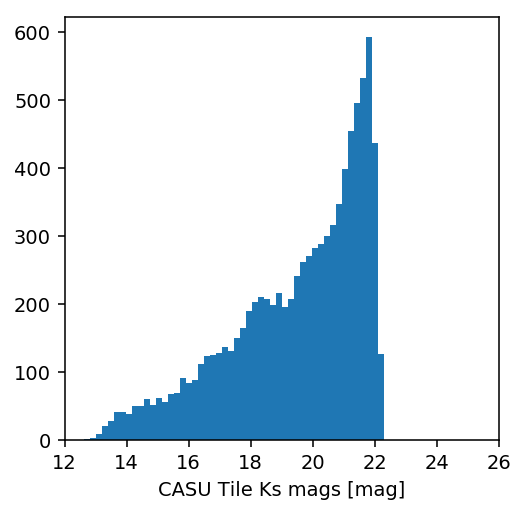

In [31]:
plt.figure(1, figsize=(4, 4), dpi=140)
m = (merge['ks_tile_m_ap_vista_ks'] > 0) & (merge['ks_tile_Classification'] == -1)
plt.hist(merge[m]['ks_tile_m_ap_vista_ks'] , bins=50)

plt.xlim([12,26])
#plt.ylim([0,450])
plt.xlabel('CASU Tile Ks mags [mag]')

Text(0.5, 0, 'HELP Ks mags [mag]')

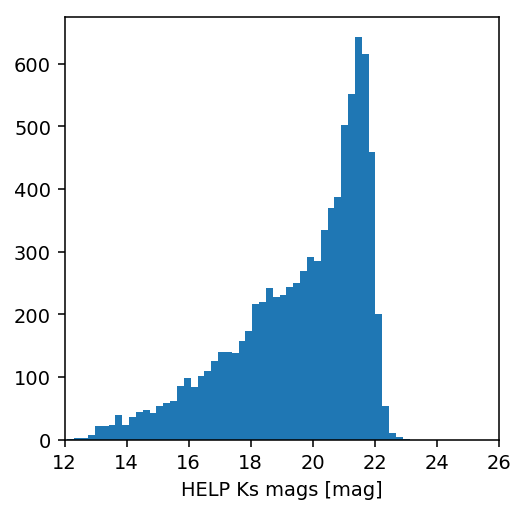

In [32]:
plt.figure(1, figsize=(4, 4), dpi=140)
m = (merge['help_m_ap_vista_ks'] < 30) & (merge['ks_tile_Classification'] == -1)
plt.hist(merge[m]['help_m_ap_vista_ks'] , bins=50)

plt.xlim([12,26])
#plt.ylim([0,450])
plt.xlabel('HELP Ks mags [mag]')

Text(0.5, 0, '2MASS Ks mags [mag]')

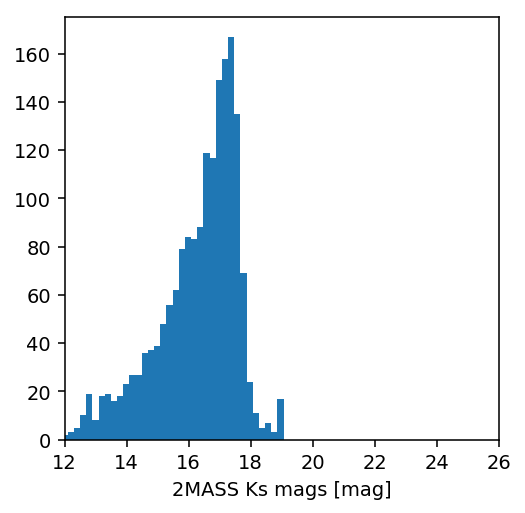

In [33]:
plt.figure(1, figsize=(4, 4), dpi=140)
m = (merge['corrected_m_2mass_ks'] < 30) & (merge['ks_tile_Classification'] == -1)
plt.hist(merge[m]['corrected_m_2mass_ks'] , bins=50)

plt.xlim([12,26])
#plt.ylim([0,450])
plt.xlabel('2MASS Ks mags [mag]')

Text(0.5, 0, 'Oxford VISTA Ks mags [mag]')

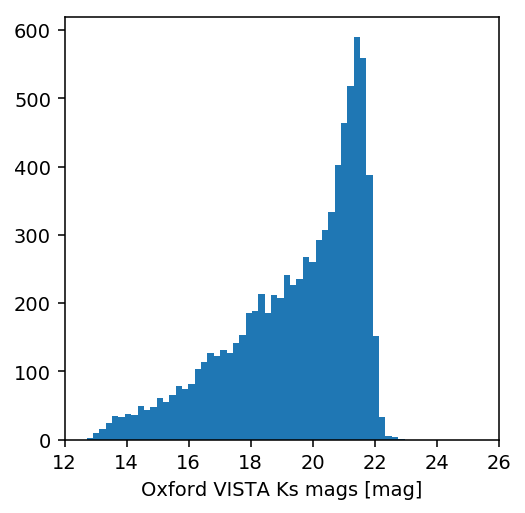

In [34]:
plt.figure(1, figsize=(4, 4), dpi=140)
m = (merge['oxford_ks_m_ap_vista_ks'] < 30) & (merge['ks_tile_Classification'] == -1)
plt.hist(merge[m]['oxford_ks_m_ap_vista_ks'] , bins=50)

plt.xlim([12,26])
#plt.ylim([0,450])
plt.xlabel('Oxford VISTA Ks mags [mag]')

Mean offset = -0.14859647587819727


Text(0, 0.5, '2MASS AB - HELP VIDEO Ks "APER 3" AB mags [mag]')

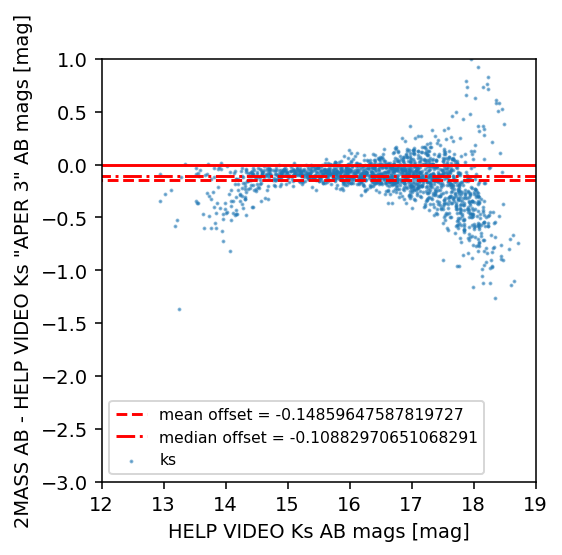

In [35]:
plt.figure(1, figsize=(4, 4), dpi=140)
m = (
    (merge['ks'] > 0) 
    & (merge['help_m_ap_vista_ks']<30) 
    & (merge['ks_tile_Classification'] == -1) 
    & (merge['help_vista_stellarity']>0.9)
)
mean_offset = np.mean((merge[m]['ks'] + ks_2mass_to_ab) - merge[m]['help_m_ap_vista_ks'])
median_offset = np.median((merge[m]['ks'] + ks_2mass_to_ab) - merge[m]['help_m_ap_vista_ks'])
print("Mean offset = {}".format(mean_offset))
plt.plot([0,26],[mean_offset,mean_offset], linestyle='--', c='r',  label = 'mean offset = {}'.format(mean_offset))
plt.plot([0,26],[median_offset,median_offset], linestyle='dashdot', c='r',
         label = 'median offset = {}'.format(median_offset))
plt.scatter(merge[m]['help_m_ap_vista_ks'],   (merge[m]['ks'] + ks_2mass_to_ab) - merge[m]['help_m_ap_vista_ks'], 
            s=1,alpha=0.5)
plt.xlabel('HELP VIDEO Ks AB mags [mag]')
plt.plot([0,26],[0,0], c='r')

plt.legend( prop={'size': 8})
plt.xlim([12,19])
plt.ylim([-3,1])
plt.ylabel('2MASS AB - HELP VIDEO Ks "APER 3" AB mags [mag]')



Mean offset = -0.12501510139887512


Text(0, 0.5, 'Oxford Ks [mag] - HELP VIDEO Ks "APER 3" AB mags [mag]')

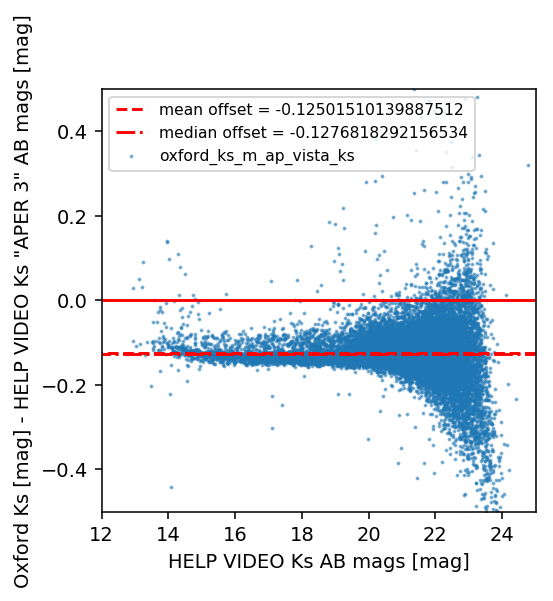

In [36]:
plt.figure(1, figsize=(4, 4), dpi=140)
m = (
    #(merge['ks'] > 0) 
     (merge['help_m_ap_vista_ks']<30) 
   # & (merge['ks_tile_Classification'] == -1) 
    & (merge['help_vista_stellarity']>0.9)
)

x_band = 'help_m_ap_vista_ks'
y_band = 'oxford_ks_m_ap_vista_ks'

mean_offset = np.nanmean((merge[m][y_band] ) - merge[m][x_band])
median_offset = np.nanmedian((merge[m][y_band] ) - merge[m][x_band])
print("Mean offset = {}".format(mean_offset))
plt.plot([0,26],[mean_offset,mean_offset], linestyle='--', c='r',  label = 'mean offset = {}'.format(mean_offset))
plt.plot([0,26],[median_offset,median_offset], linestyle='dashdot', c='r',
         label = 'median offset = {}'.format(median_offset))
plt.scatter(merge[m][x_band],   (merge[m][y_band] ) - merge[m][x_band], 
            s=1,alpha=0.5)
plt.xlabel('HELP VIDEO Ks AB mags [mag]')
plt.plot([0,26],[0,0], c='r')

plt.legend( prop={'size': 8})
plt.xlim([12,25])
plt.ylim([-0.5,0.5])
plt.ylabel('Oxford Ks [mag] - HELP VIDEO Ks "APER 3" AB mags [mag]')

Mean offset = -0.19360739384473782
Median offset = -0.12158874670410214


Text(0, 0.5, '2MASS Corrected - HELP VIDEO Ks AB mags [mag]')

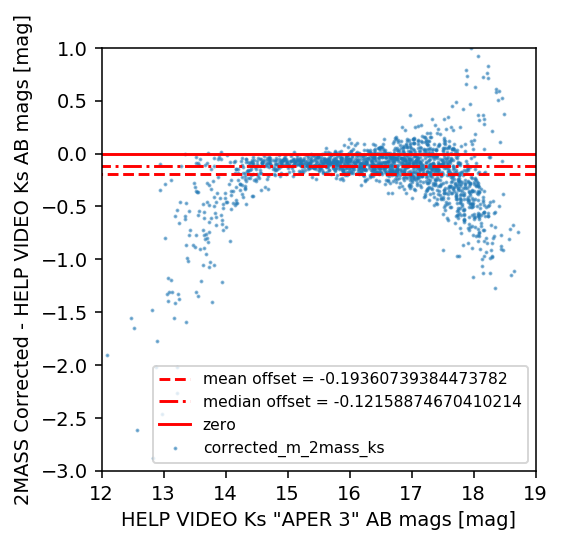

In [37]:
plt.figure(1, figsize=(4, 4), dpi=140)
m = (
    (merge['ks'] > 0) 
    & (merge['help_m_ap_vista_ks']<30) 
    & (merge['ks_tile_Classification'] == -1) 
    #& (merge['help_vista_stellarity']>0.9)
)
mean_offset = np.mean(merge[m]['corrected_m_2mass_ks'] - merge[m]['help_m_ap_vista_ks']) 
median_offset = np.median(merge[m]['corrected_m_2mass_ks'] - merge[m]['help_m_ap_vista_ks'])
print("Mean offset = {}".format(mean_offset))
print("Median offset = {}".format(median_offset))
plt.plot([0,26],[mean_offset,mean_offset], linestyle='--', c='r', label = 'mean offset = {}'.format(mean_offset))
plt.plot([0,26],[median_offset,median_offset], linestyle='dashdot', c='r',
         label = 'median offset = {}'.format(median_offset))
plt.plot([0,26],[0,0], c='r', label='zero')
plt.scatter(merge[m]['help_m_ap_vista_ks'],   merge[m]['corrected_m_2mass_ks'] - merge[m]['help_m_ap_vista_ks'],
            s=1,alpha=0.5)

plt.legend( prop={'size': 8})
plt.xlim([12,19])
plt.ylim([-3,1.])
plt.xlabel('HELP VIDEO Ks "APER 3" AB mags [mag]')
plt.ylabel('2MASS Corrected - HELP VIDEO Ks AB mags [mag]')


Mean offset = -0.1550954943271009
Median offset = -0.11502489434814489


Text(0, 0.5, '2MASS Corrected - HELP VIDEO Ks AB mags [mag]')

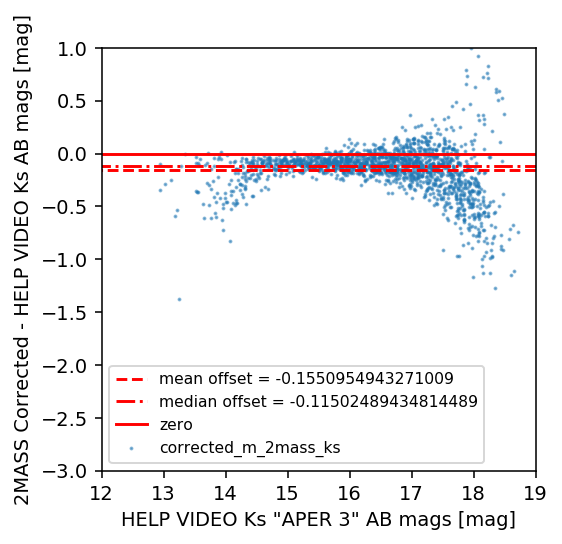

In [38]:
plt.figure(1, figsize=(4, 4), dpi=140)
m = (
    (merge['ks'] > 0) 
    & (merge['help_m_ap_vista_ks']<30) 
    & (merge['ks_tile_Classification'] == -1) 
    & (merge['help_vista_stellarity']>0.9)
)
mean_offset = np.mean(merge[m]['corrected_m_2mass_ks'] - merge[m]['help_m_ap_vista_ks']) 
median_offset = np.median(merge[m]['corrected_m_2mass_ks'] - merge[m]['help_m_ap_vista_ks'])
print("Mean offset = {}".format(mean_offset))
print("Median offset = {}".format(median_offset))
plt.plot([0,26],[mean_offset,mean_offset], linestyle='--', c='r', label = 'mean offset = {}'.format(mean_offset))
plt.plot([0,26],[median_offset,median_offset], linestyle='dashdot', c='r',
         label = 'median offset = {}'.format(median_offset))
plt.plot([0,26],[0,0], c='r', label='zero')
plt.scatter(merge[m]['help_m_ap_vista_ks'],   merge[m]['corrected_m_2mass_ks'] - merge[m]['help_m_ap_vista_ks'],
            s=1,alpha=0.5)

plt.legend( prop={'size': 8})
plt.xlim([12,19])
plt.ylim([-3,1.])
plt.xlabel('HELP VIDEO Ks "APER 3" AB mags [mag]')
plt.ylabel('2MASS Corrected - HELP VIDEO Ks AB mags [mag]')


Text(0.5, 0, '2MASS Corrected - HELP VIDEO Ks AB mags [mag]')

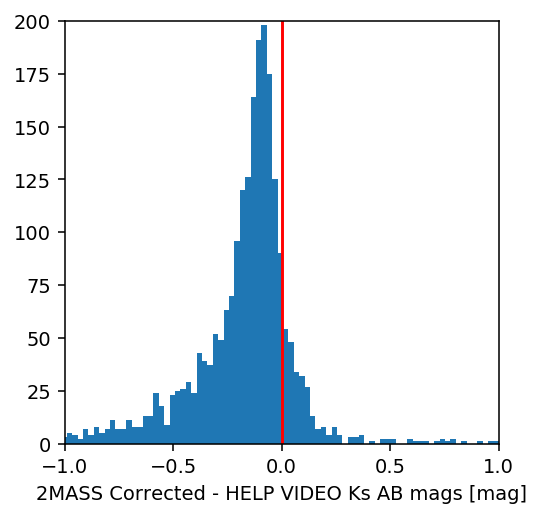

In [39]:
plt.figure(1, figsize=(4, 4), dpi=140)
m = (merge['j'] > 0) & (merge['help_m_ap_vista_ks']<30)
plt.hist(merge[m]['corrected_m_2mass_ks'] - merge[m]['help_m_ap_vista_ks'], bins=200)
plt.vlines(0, 0,1000, colors='r')
plt.xlim([-1,1])
plt.ylim([0,200])
plt.xlabel('2MASS Corrected - HELP VIDEO Ks AB mags [mag]')

Text(0.5, 0, '2MASS Corrected (Ks<12) - HELP VIDEO Ks AB mags [mag]')

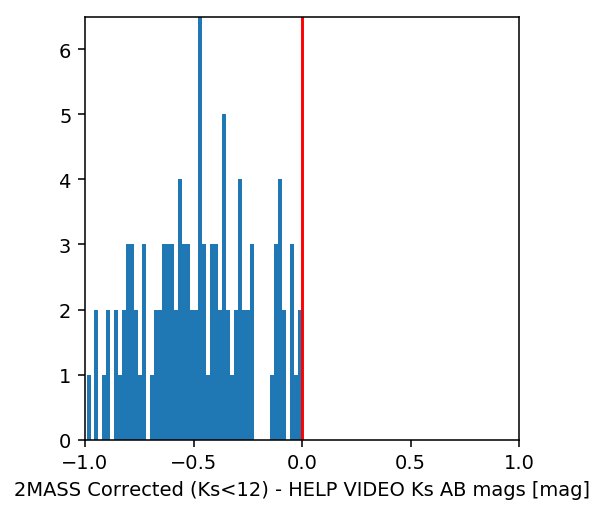

In [40]:
plt.figure(1, figsize=(4, 4), dpi=140)
m = (merge['ks'] <12) & (merge['help_m_ap_vista_ks']<30)
plt.hist(merge[m]['corrected_m_2mass_ks'] - merge[m]['help_m_ap_vista_ks'], bins=200)
plt.vlines(0, 0,7, colors='r')
plt.xlim([-1,1])
plt.ylim([0,6.5])
plt.xlabel('2MASS Corrected (Ks<12) - HELP VIDEO Ks AB mags [mag]')

Mean offset = -0.033405153132087285


Text(0, 0.5, 'Oxford Ks - 2MASS corrected [mag]')

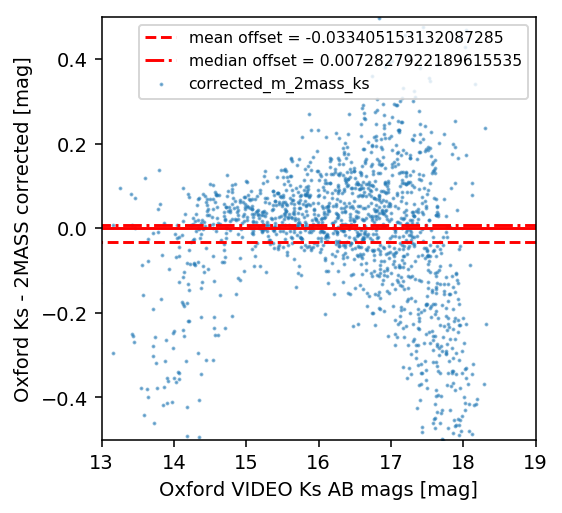

In [41]:
plt.figure(1, figsize=(4, 4), dpi=140)
m = (
    #(merge['ks'] > 0) 
     (merge['help_m_ap_vista_ks']<30) 
   # & (merge['ks_tile_Classification'] == -1) 
    & (merge['help_vista_stellarity']>0.9)
)

x_band = 'oxford_ks_m_ap_vista_ks'
y_band = 'corrected_m_2mass_ks'

mean_offset = np.nanmean((merge[m][y_band] ) - merge[m][x_band])
median_offset = np.nanmedian((merge[m][y_band] ) - merge[m][x_band])
print("Mean offset = {}".format(mean_offset))
plt.plot([0,26],[mean_offset,mean_offset], linestyle='--', c='r',  label = 'mean offset = {}'.format(mean_offset))
plt.plot([0,26],[median_offset,median_offset], linestyle='dashdot', c='r',
         label = 'median offset = {}'.format(median_offset))
plt.scatter(merge[m][x_band],   (merge[m][y_band] ) - merge[m][x_band], 
            s=1,alpha=0.5)
plt.xlabel('Oxford VIDEO Ks AB mags [mag]')
plt.plot([0,26],[0,0], c='r')

plt.legend( prop={'size': 8})
plt.xlim([13,19])
plt.ylim([-0.5,0.5])
plt.ylabel('Oxford Ks - 2MASS corrected [mag]')

Mean offset = 0.0727760026848518


Text(0, 0.5, 'CASU Ks tile - Oxford Ks [mag]')

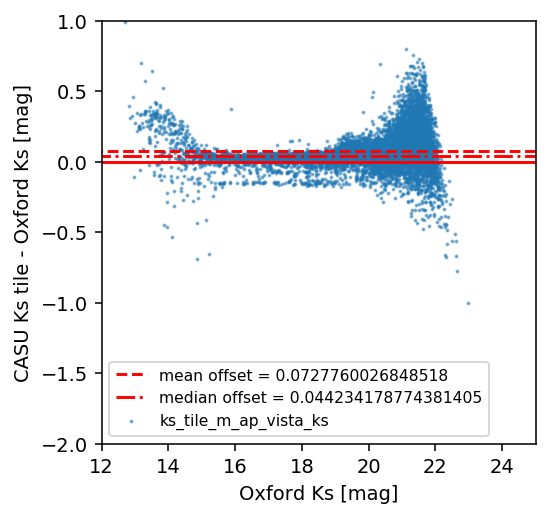

In [42]:
plt.figure(1, figsize=(4, 4), dpi=140)
m = (
    #(merge['ks'] > 0) 
     #(merge['help_m_ap_vista_ks']<30) 
   (merge['ks_tile_Classification'] == -1) 
   # & (merge['help_vista_stellarity']>0.9)
)

x_band, x_name = 'oxford_ks_m_ap_vista_ks', 'Oxford Ks'
y_band, y_name = 'ks_tile_m_ap_vista_ks', 'CASU Ks tile'

mean_offset = np.nanmean((merge[m][y_band] ) - merge[m][x_band])
median_offset = np.nanmedian((merge[m][y_band] ) - merge[m][x_band])
print("Mean offset = {}".format(mean_offset))
plt.plot([0,26],[mean_offset,mean_offset], linestyle='--', c='r',  label = 'mean offset = {}'.format(mean_offset))
plt.plot([0,26],[median_offset,median_offset], linestyle='dashdot', c='r',
         label = 'median offset = {}'.format(median_offset))
plt.scatter(merge[m][x_band],   (merge[m][y_band] ) - merge[m][x_band], 
            s=1,alpha=0.5)
plt.xlabel(x_name + ' [mag]')
plt.plot([0,26],[0,0], c='r')

plt.legend( prop={'size': 8})
plt.xlim([12,25])
plt.ylim([-2,1])
plt.ylabel('{} - {} [mag]'.format(y_name,x_name))

Text(0.5, 0, 'CASU Ks tile - Oxford Ks [mag]')

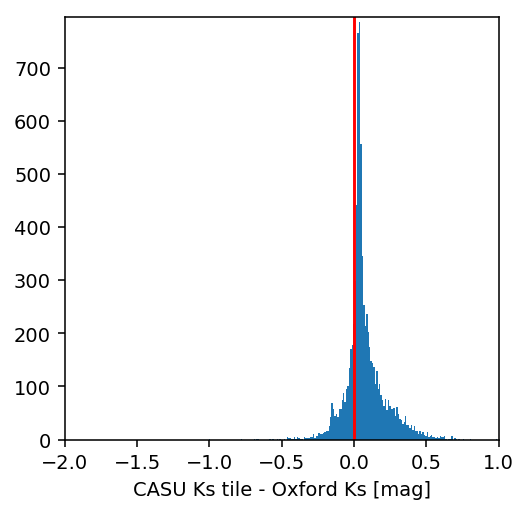

In [43]:
x_band, x_name = 'oxford_ks_m_ap_vista_ks', 'Oxford Ks'
y_band, y_name = 'ks_tile_m_ap_vista_ks', 'CASU Ks tile'
m = (
    #merge['ks_tile_m_ap_vista_ks'] > 0) 
     (merge['ks_tile_Classification'] == -1)
    #& (merge['help_m_ap_vista_ks']<30)
)
plt.figure(1, figsize=(4, 4), dpi=140)

h = plt.hist(merge[m][y_band] - merge[m][x_band], bins=200)
plt.vlines(0, 0,1000, colors='r')
plt.xlim([-2,1])
plt.ylim([0,np.max(h[0]) + 10])
plt.xlabel('{} - {} [mag]'.format(y_name,x_name))

Mean offset = -0.19743943765781363
Median offset = -0.12223829873480341


Text(0, 0.5, '2MASS AB - HELP VIDEO Ks AB mags [mag]')

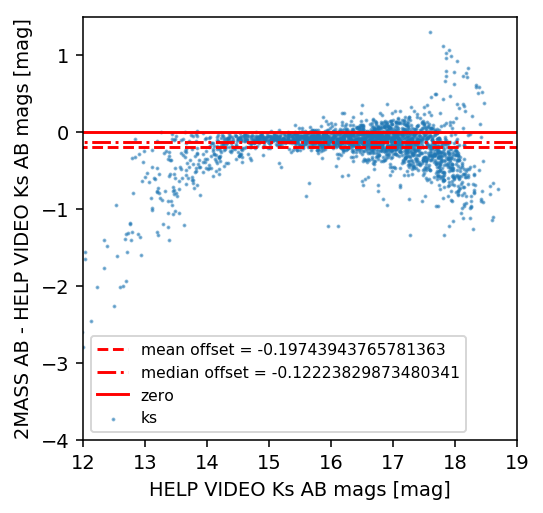

In [44]:
plt.figure(1, figsize=(4, 4), dpi=140)
m = (merge['ks'] > 0) &(merge['help_m_ap_vista_ks'] <30)

plt.scatter(merge[m]['help_m_vista_ks'],   merge[m]['ks'] + ks_2mass_to_ab - merge[m]['help_m_ap_vista_ks'], 
            s=1,alpha=0.5)

mean_offset = np.mean(merge[m]['ks'] + ks_2mass_to_ab  - merge[m]['help_m_ap_vista_ks'])
median_offset = np.median(merge[m]['ks'] + ks_2mass_to_ab  - merge[m]['help_m_ap_vista_ks'])
print("Mean offset = {}".format(mean_offset))

print("Median offset = {}".format(median_offset))
plt.plot([0,26],[mean_offset,mean_offset], linestyle='--', c='r', label = 'mean offset = {}'.format(mean_offset))
plt.plot([0,26],[median_offset,median_offset], linestyle='dashdot', c='r',
         label = 'median offset = {}'.format(median_offset))
plt.plot([0,26],[0,0], c='r', label='zero')


plt.legend( prop={'size': 8})
plt.xlim([12,19])
plt.ylim([-4,1.5])
plt.xlabel('HELP VIDEO Ks AB mags [mag]')
plt.ylabel('2MASS AB - HELP VIDEO Ks AB mags [mag]')

Mean offset = -0.07610639929771423
Median offset = -0.0967702865600586


Text(0, 0.5, 'CASU Tile - HELP AB mags [mag]')

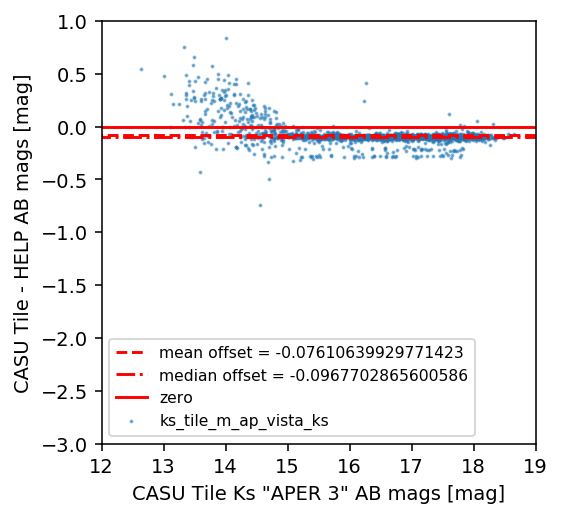

In [45]:
plt.figure(1, figsize=(4, 4), dpi=140)
m = (merge['ks'] > 0) & (merge['help_m_ap_vista_ks']<30) & (merge['ks_tile_Classification'] == -1)
mean_offset = np.mean(merge[m]['ks_tile_m_ap_vista_ks'] - merge[m]['help_m_ap_vista_ks']) 
median_offset = np.median(merge[m]['ks_tile_m_ap_vista_ks'] - merge[m]['help_m_ap_vista_ks'])
print("Mean offset = {}".format(mean_offset))
print("Median offset = {}".format(median_offset))
plt.plot([0,26],[mean_offset,mean_offset], linestyle='--', c='r', label = 'mean offset = {}'.format(mean_offset))
plt.plot([0,26],[median_offset,median_offset], linestyle='dashdot', c='r',
         label = 'median offset = {}'.format(median_offset))
plt.plot([0,26],[0,0], c='r', label='zero')
plt.scatter(merge[m]['ks_tile_m_ap_vista_ks'],   merge[m]['ks_tile_m_ap_vista_ks'] - merge[m]['help_m_ap_vista_ks'],
            s=1,alpha=0.5)

plt.legend( prop={'size': 8})
plt.xlim([12,19])
plt.ylim([-3,1.])
plt.xlabel('CASU Tile Ks "APER 3" AB mags [mag]')
plt.ylabel('CASU Tile - HELP AB mags [mag]')

Text(0.5, 0, 'CASU - HELP VIDEO Ks AB mags [mag]')

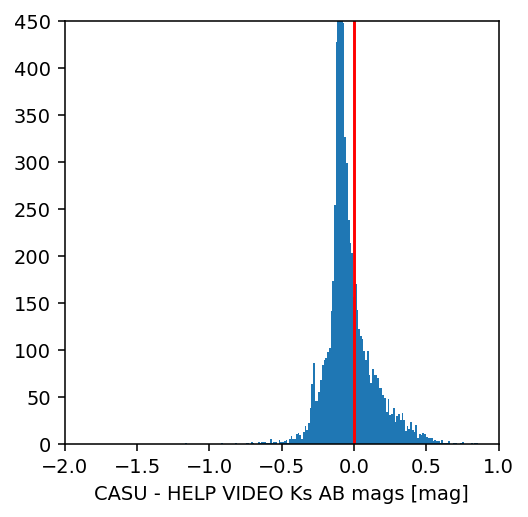

In [46]:
plt.figure(1, figsize=(4, 4), dpi=140)
m = (merge['ks_tile_m_ap_vista_ks'] > 0) & (merge['ks_tile_Classification'] == -1)& (merge['help_m_ap_vista_ks']<30)
plt.hist(merge[m]['ks_tile_m_ap_vista_ks'] - merge[m]['help_m_ap_vista_ks'], bins=200)
plt.vlines(0, 0,1000, colors='r')
plt.xlim([-2,1])
plt.ylim([0,450])
plt.xlabel('CASU - HELP VIDEO Ks AB mags [mag]')

Mean offset = 0.11700971705897924
Median offset = 0.025811666442871584


Text(0, 0.5, 'CASU Tile - 2MASS corrected AB mags [mag]')

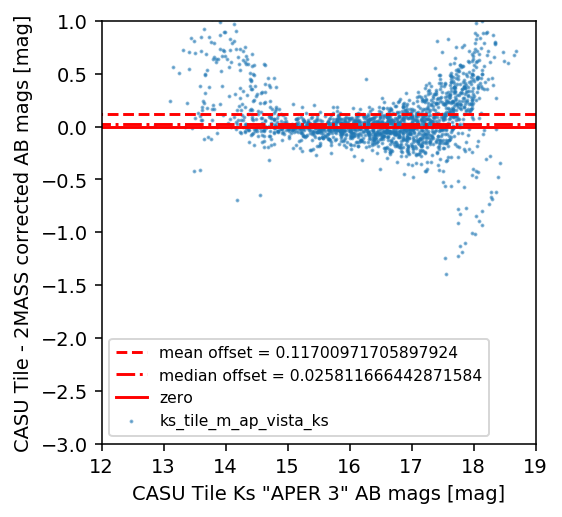

In [47]:
plt.figure(1, figsize=(4, 4), dpi=140)
m = (merge['ks'] > 0) & (merge['corrected_m_2mass_ks']<30) & (merge['ks_tile_Classification'] == -1)
mean_offset = np.mean(merge[m]['ks_tile_m_ap_vista_ks'] - merge[m]['corrected_m_2mass_ks']) 
median_offset = np.median(merge[m]['ks_tile_m_ap_vista_ks'] - merge[m]['corrected_m_2mass_ks'])
print("Mean offset = {}".format(mean_offset))
print("Median offset = {}".format(median_offset))
plt.plot([0,26],[mean_offset,mean_offset], linestyle='--', c='r', label = 'mean offset = {}'.format(mean_offset))
plt.plot([0,26],[median_offset,median_offset], linestyle='dashdot', c='r',
         label = 'median offset = {}'.format(median_offset))
plt.plot([0,26],[0,0], c='r', label='zero')
plt.scatter(merge[m]['ks_tile_m_ap_vista_ks'],   merge[m]['ks_tile_m_ap_vista_ks'] - merge[m]['corrected_m_2mass_ks'],
            s=1,alpha=0.5)

plt.legend( prop={'size': 8})
plt.xlim([12,19])
plt.ylim([-3,1.])
plt.xlabel('CASU Tile Ks "APER 3" AB mags [mag]')
plt.ylabel('CASU Tile - 2MASS corrected AB mags [mag]')

Mean offset = 0.11700971705897924
Median offset = 0.025811666442871584


Text(0, 0.5, 'CASU Tile - 2MASS corrected AB mags [mag]')

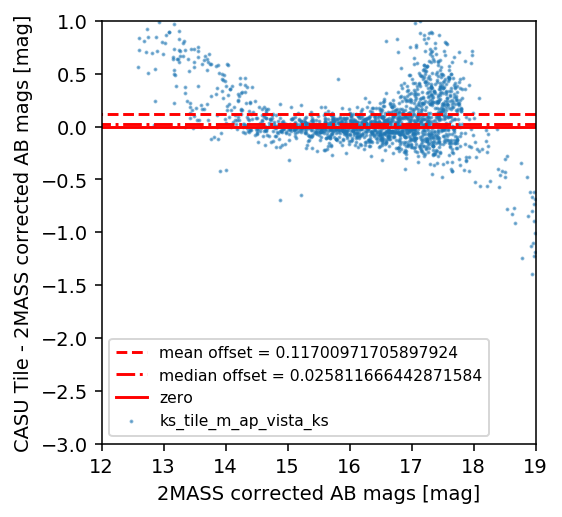

In [48]:
plt.figure(1, figsize=(4, 4), dpi=140)
m = (merge['ks'] > 0) & (merge['corrected_m_2mass_ks']<30) & (merge['ks_tile_Classification'] == -1)
mean_offset = np.mean(merge[m]['ks_tile_m_ap_vista_ks'] - merge[m]['corrected_m_2mass_ks']) 
median_offset = np.median(merge[m]['ks_tile_m_ap_vista_ks'] - merge[m]['corrected_m_2mass_ks'])
print("Mean offset = {}".format(mean_offset))
print("Median offset = {}".format(median_offset))
plt.plot([0,26],[mean_offset,mean_offset], linestyle='--', c='r', label = 'mean offset = {}'.format(mean_offset))
plt.plot([0,26],[median_offset,median_offset], linestyle='dashdot', c='r',
         label = 'median offset = {}'.format(median_offset))
plt.plot([0,26],[0,0], c='r', label='zero')
plt.scatter(merge[m]['corrected_m_2mass_ks'],   merge[m]['ks_tile_m_ap_vista_ks'] - merge[m]['corrected_m_2mass_ks'],
            s=1,alpha=0.5)

plt.legend( prop={'size': 8})
plt.xlim([12,19])
plt.ylim([-3,1.])
plt.xlabel('2MASS corrected AB mags [mag]')
plt.ylabel('CASU Tile - 2MASS corrected AB mags [mag]')

Mean offset = 0.1105759045950756
Median offset = 0.019167650541444203


Text(0, 0.5, 'CASU Tile - 2MASS AB mags [mag]')

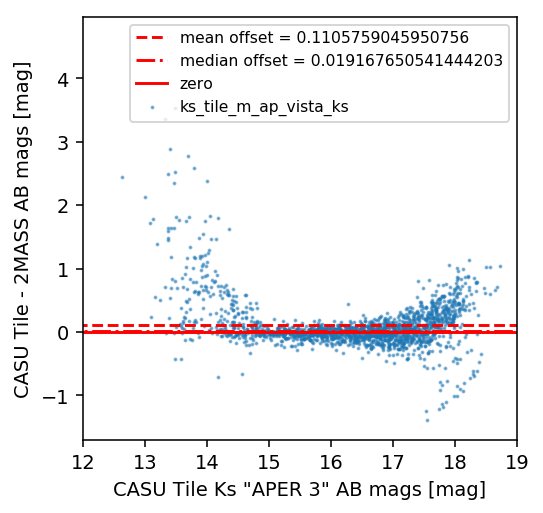

In [49]:
plt.figure(1, figsize=(4, 4), dpi=140)
m = (merge['ks'] > 0) & (merge['corrected_m_2mass_ks']<30) & (merge['ks_tile_Classification'] == -1)
mean_offset = np.mean(merge[m]['ks_tile_m_ap_vista_ks'] - (merge[m]['ks'] + ks_2mass_to_ab) )
median_offset = np.median(merge[m]['ks_tile_m_ap_vista_ks'] - (merge[m]['ks'] + ks_2mass_to_ab))
print("Mean offset = {}".format(mean_offset))
print("Median offset = {}".format(median_offset))
plt.plot([0,26],[mean_offset,mean_offset], linestyle='--', c='r', label = 'mean offset = {}'.format(mean_offset))
plt.plot([0,26],[median_offset,median_offset], linestyle='dashdot', c='r',
         label = 'median offset = {}'.format(median_offset))
plt.plot([0,26],[0,0], c='r', label='zero')
plt.scatter(merge[m]['ks_tile_m_ap_vista_ks'],   merge[m]['ks_tile_m_ap_vista_ks'] - (merge[m]['ks'] + ks_2mass_to_ab),
            s=1,alpha=0.5)

plt.legend( prop={'size': 8})
plt.xlim([12,19])
#plt.ylim([-3,1.])
plt.xlabel('CASU Tile Ks "APER 3" AB mags [mag]')
plt.ylabel('CASU Tile - 2MASS AB mags [mag]')

Text(0.5, 0, 'CASU - 2MASS corrected Ks AB mags [mag]')

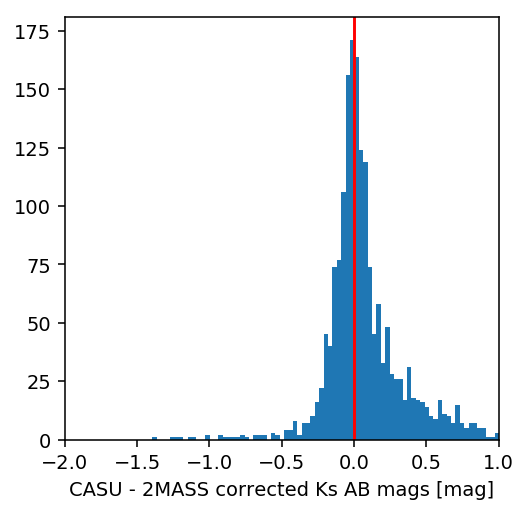

In [50]:
plt.figure(1, figsize=(4, 4), dpi=140)
m = (merge['ks'] > 0) & (merge['corrected_m_2mass_ks']<30) & (merge['ks_tile_Classification'] == -1)
h = plt.hist(merge[m]['ks_tile_m_ap_vista_ks'] - merge[m]['corrected_m_2mass_ks'], bins=200)
plt.vlines(0, 0,1000, colors='r')
plt.xlim([-2,1])
plt.ylim([0,np.max(h[0]) +10])
plt.xlabel('CASU - 2MASS corrected Ks AB mags [mag]')

## Write catalogue for future comparisons
We will use the catalogue produced here for comparison to the test region in SXDS in DMU4/DMU4_Example

In [51]:
merge.write('./data/video_xmm-lss_baseline.fits', overwrite=True)